In [1]:
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ekf import EKF
from pf import PF
from data_handler import DataHandler

In [3]:
data_handler = DataHandler(data_dir="data_csv",Q1_scale=10)
init_x = np.array([1, 1, 1])
init_cov = np.eye(3)*10
particles = 1000
particle_filter = PF(particles, data_handler.Q1, data_handler.process_func)

# Comparing EKF and PF with Batch updates

## Training EKF

### EKF details
This code snippet appears to be implementing a Kalman filter (EKF) for a system with two cameras. Here's a breakdown of what the code does:

1. It initializes the state vector `x` and the covariance matrix `cov` with the values from `init_x` and `init_cov`.
2. It assigns the value of `data_handler.Q1` to the variable `Q`, which represents the process noise covariance.
3. It constructs the `R_stacked` matrix by stacking `data_handler.R1` and `data_handler.R2` horizontally, and then adding zeros to the lower right corner.
4. It initializes an empty list called `positions_ekf`.
5. It iterates over the `z_1` and `z_2` measurements from `data_handler`, and for each pair of measurements:
   - It reshapes `x` into a 1D array.
   - It appends the current state vector `x` to the `positions_ekf` list.
   - It concatenates `z_1` and `z_2` into a single vector `z`.
   - It calculates the Jacobian matrices `H1` and `H2` using the `h1_jacobian` and `h2_jacobian` functions from `data_handler`.
   - It stacks `H1` and `H2` vertically to form the `H` matrix.
   - It calculates the predicted measurements `pred_z1` and `pred_z2` using the `h1_func` and `h2_func` functions from `data_handler`.
   - It concatenates `pred_z1` and `pred_z2` into a single vector `pred_z`.
   - It calls the `EKF` function with the current state vector `x`, covariance matrix `cov`, `H`, `Q`, `R_stacked`, `z`, and `pred_z`, and updates `x` and `cov` with the returned values.


In [4]:
x = init_x.copy()
cov = init_cov.copy()
Q = data_handler.Q1 
R_stacked = np.block([[data_handler.R1, np.zeros((2, 2))],[np.zeros((2, 2)), data_handler.R2]])

positions_ekf = []
for z_1, z_2 in zip(data_handler.z1, data_handler.z2):
    x = x.reshape(-1,)
    positions_ekf.append(x)
    z = np.hstack((z_1, z_2))
    H1 = data_handler.h1_jacobian(x)
    H2 = data_handler.h2_jacobian(x)
    H = np.vstack((H1, H2))

    pred_z1 = data_handler.h1_func(x)
    pred_z2 = data_handler.h2_func(x)
    pred_z = np.hstack((pred_z1, pred_z2))

    x,cov = EKF(x, cov, H, Q, R_stacked, z, pred_z)

    # print(x.shape, cov.shape)
    # print(H.shape)
    # print(z.shape)
print(x)

[[0.93270254]
 [0.02353253]
 [0.48149394]]


## Training PF

### PF details
This code snippet is implementing a Particle Filter (PF) algorithm for a system with two sensors. Here's a succinct explanation:

1. It sets the process noise covariance `Q` to `data_handler.Q1`.
2. It constructs the measurement noise covariance matrix `R_stacked` by combining the noise covariances of the two sensors (`data_handler.R1` and `data_handler.R2`) into a single matrix.
3. It defines a function `h_func` that predicts the measurements for a given state `x` by calling `data_handler.h1_func` and `data_handler.h2_func` and concatenating the results.
4. It iterates over the measurements from the two sensors (`z_1` and `z_2`) and for each pair of measurements:
   - It concatenates the measurements into a single vector `z`.
   - It updates the particle filter by sampling the motion model (`particle_filter.sample_motion`).
   - It appends the mean of the particle filter's state to the `positions_pf` list.
   - It updates the particle filter by importance sampling using the predicted measurements (`h_func`), the actual measurement (`z`), and the measurement noise covariance (`R_stacked`).

In [5]:
Q = data_handler.Q1 
R_stacked = np.block([[data_handler.R1, np.zeros((2, 2))],[np.zeros((2, 2)), data_handler.R2]])

positions_pf = []
def h_func(x):
    pred_z1 = data_handler.h1_func(x) 
    pred_z2 = data_handler.h2_func(x)
    return np.hstack((pred_z1, pred_z2))

for z_1, z_2 in zip(data_handler.z1, data_handler.z2):
    z = np.hstack((z_1, z_2))
    particle_filter.sample_motion()
    positions_pf.append(particle_filter.x.mean(axis=0))
    particle_filter.importance_sampling(z, h_func, R_stacked)


    # print(particle_filter.x.mean(axis=0))
    # print(x.shape, cov.shape)
    # print(H.shape)
    # print(z.shape)

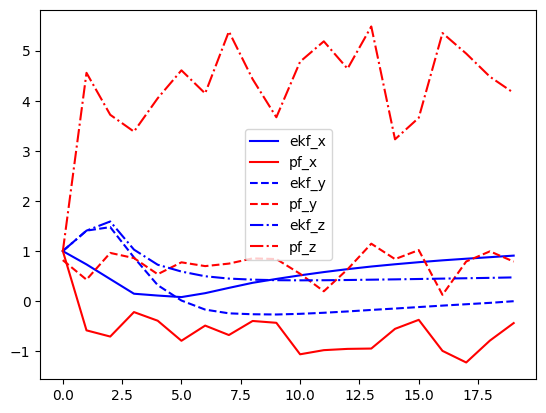

In [7]:
positions_ekf = np.array(positions_ekf)
positions_pf = np.array(positions_pf)
plt.plot(np.arange(positions_ekf.shape[0]), positions_ekf[:,0], label='ekf_x', c = 'b', ls='-' )
plt.plot(np.arange(positions_pf.shape[0]), positions_pf[:,0], label='pf_x', c = 'r', ls='-' )
plt.plot(np.arange(positions_ekf.shape[0]), positions_ekf[:,1], label='ekf_y', c = 'b', ls='--' )
plt.plot(np.arange(positions_pf.shape[0]), positions_pf[:,1], label='pf_y', c = 'r', ls='--' )
plt.plot(np.arange(positions_ekf.shape[0]), positions_ekf[:,2], label='ekf_z', c = 'b', ls='-.' )
plt.plot(np.arange(positions_pf.shape[0]), positions_pf[:,2], label='pf_z', c = 'r', ls='-.' )

plt.legend()
plt.show()
plt.close()